<a href="https://colab.research.google.com/github/hyunwookim129/Resnet_Pneu_Grad/blob/main/ResNet_pneua_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:17<00:00, 142MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import shutil

# For computing class weights
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

In [5]:
# For Google Drive mounting (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define dataset directories
train_image_path = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train')
val_image_path   = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')
test_image_path  = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test')

print("\n=== Checking training folder structure ===")
train_classes = os.listdir(train_image_path)
print("Classes in train folder:", train_classes)

normal_images     = os.listdir(train_image_path / "NORMAL")
pneumonia_images  = os.listdir(train_image_path / "PNEUMONIA")
num_normal_images = len(normal_images)
num_pneumonia_img = len(pneumonia_images)
print(f"Number of NORMAL images:    {num_normal_images}")
print(f"Number of PNEUMONIA images: {num_pneumonia_img}")

print("\n=== Merging original 'val' folder into 'train', then re-splitting ===")
for folder in ['NORMAL', 'PNEUMONIA']:
    val_folder   = val_image_path / folder
    train_folder = train_image_path / folder
    for img_file in os.listdir(val_folder):
        shutil.move(str(val_folder / img_file), str(train_folder))

# Now we re-split the combined train data into new train & validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)
test_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 16
img_size   = (150, 150)

train_generator = train_datagen.flow_from_directory(
    train_image_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_image_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_image_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# Check class distribution in train/val
train_labels = train_generator.labels
val_labels   = val_generator.labels
train_bincnt = np.bincount(train_labels)
val_bincnt   = np.bincount(val_labels)
class_names  = list(train_generator.class_indices.keys())

for i, cls_name in enumerate(class_names):
    print(f"Train - {cls_name}: {train_bincnt[i]}")
    print(f"Val   - {cls_name}: {val_bincnt[i]}")


print("\n=== Computing class weights ===")
cw_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(cw_values))
print("Class Weights:", class_weights_dict)


=== Checking training folder structure ===
Classes in train folder: ['PNEUMONIA', 'NORMAL']
Number of NORMAL images:    1341
Number of PNEUMONIA images: 3875

=== Merging original 'val' folder into 'train', then re-splitting ===
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples:   4187
Validation samples: 1045
Train - NORMAL: 1080
Val   - NORMAL: 269
Train - PNEUMONIA: 3107
Val   - PNEUMONIA: 776

=== Computing class weights ===
Class Weights: {0: 1.938425925925926, 1: 0.6738010943031864}


In [10]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

# Custom Fully Connected Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(1, activation='sigmoid')(x)  # Apply Dense layer to previous output

# Define Final Model
model = Model(inputs=base_model.input, outputs=output_tensor)  # Use the output tensor

# Compile Model
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 23,796,993 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_resnet50_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train Model with Class Weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8789 - loss: 0.2876
Epoch 1: val_loss improved from inf to 1.35228, saving model to best_resnet50_model.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 191s 448ms/step - accuracy: 0.8790 - loss: 0.2873 - val_accuracy: 0.2574 - val_loss: 1.3523 - learning_rate: 1.0000e-04
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9418 - loss: 0.1400
Epoch 2: val_loss improved from 1.35228 to 0.72876, saving model to best_resnet50_model.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 135s 305ms/step - accuracy: 0.9419 - loss: 0.1400 - val_accuracy: 0.7426 - val_loss: 0.7288 - learning_rate: 1.0000e-04
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9507 - loss: 0.1153
Epoch 3: val_loss did not improve from 0.72876
262/262 ━━━━━━━━━━━━━━━━━━━━ 87s 322ms/step - accuracy: 0.9507 - loss: 0.1153 - val_accuracy: 0.7426 - val_loss: 0.8709 - learning_rate: 1.0000e-04
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.95

In [13]:
# Save the trained model
model.save("/content/drive/My Drive/ResNet_pneu_model.keras")
model.save("/content/drive/My Drive/ResNet_pneu_model.h5")

# Load the model for Grad-CAM
loaded_model = tf.keras.models.load_model("/content/drive/My Drive/ResNet_pneu_model.keras")

print("✅ Model saved and loaded successfully!")

✅ Model saved and loaded successfully!


In [22]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out", pred_index=None):
    """
    Generates a Grad-CAM heatmap with improved gradient scaling and contrast.
    """
    # Get the convolutional layer & model output
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record operations
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)

        # Select class index (ensure it's correct for binary/multi-class cases)
        if pred_index is None:
            if preds.shape[-1] == 1:  # Binary classification
                pred_index = 0
            else:
                pred_index = tf.argmax(preds[0])

        class_channel = preds[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Check if gradients are None
    if grads is None:
        raise ValueError(f"❌ Gradients are None. The model might not be built correctly, or the selected layer '{last_conv_layer_name}' may not support backpropagation.\n"
                         "💡 Try selecting an earlier convolutional layer (e.g., conv2 instead of conv3).")

    # Normalize gradients (avoid vanishing/exploding values)
    grads = (grads - tf.reduce_mean(grads)) / (tf.math.reduce_std(grads) + 1e-8)

    # Compute global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight each feature map by importance
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap for better contrast
    heatmap = (heatmap - np.percentile(heatmap, 5)) / (np.percentile(heatmap, 99) - np.percentile(heatmap, 5) + 1e-8)
    heatmap = np.clip(heatmap, 0, 1)
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit for visualization

    return heatmap


def show_gradcam(original_img, heatmap, alpha=0.6):
    """
    Overlays a Grad-CAM heatmap on the original image.
    """
    # Apply improved colormap for better contrast
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)

    # Resize heatmap to match original image size
    jet_heatmap = cv2.resize(jet_heatmap, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Normalize original image to [0, 255] range for consistent brightness
    original_img = (original_img - np.min(original_img)) / (np.max(original_img) - np.min(original_img) + 1e-8) * 255
    original_img = original_img.astype(np.uint8)

    # Convert images to float32 for proper blending
    original_img = original_img.astype(np.float32)
    jet_heatmap = jet_heatmap.astype(np.float32)

    # Blend heatmap with original image (adjust transparency)
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, jet_heatmap, alpha, 0)

    return np.uint8(superimposed_img)  # Convert back to uint8 for display


In [24]:
last_conv_layer_name = "conv5_block3_out"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap from a given model and image tensor.
    """

    # ✅ Grad-CAM 모델 생성 (마지막 Conv Layer + 최종 출력)
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,  # 마지막 Conv Layer의 Feature Map
            model.output  # 모델 예측값
        ]
    )

    # ✅ Gradient Tape를 사용하여 Backpropagation 추적
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)  # Conv Layer 활성화 맵, 모델 예측값
        if pred_index is None:
            pred_index = tf.argmax(preds[0]) if preds.shape[-1] > 1 else 0  # 이진 분류일 경우 index=0

        # ✅ 선택한 클래스의 예측 확률을 기반으로 Gradient 계산
        class_channel = preds[:, pred_index]

    # ✅ Conv Layer에 대한 Gradient 계산
    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        raise ValueError(f"Gradients are None. Check that layer '{last_conv_layer_name}' is valid for backprop.")

    # ✅ Global Average Pooling (H, W 축에 대해 평균 내기)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    # ✅ Feature Map에 대한 중요도 적용
    conv_outputs = conv_outputs[0].numpy()  # (H, W, C)
    pooled_grads = pooled_grads[0].numpy()  # (C,)

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # ✅ Feature Map 합산 및 ReLU 적용
    heatmap = np.sum(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)

    # ✅ Normalize the heatmap to [0, 1]
    max_val = heatmap.max() if heatmap.max() != 0 else 1e-8
    heatmap /= max_val

    # ✅ Convert to 8-bit
    heatmap = np.uint8(255 * heatmap)
    return heatmap

def overlay_gradcam(original_img, heatmap, alpha=0.4, threshold=0.1):
    """
    Overlays a Grad-CAM heatmap onto the original image with transparency.
    """

    # ✅ 1) Heatmap이 2D인지 확인하고 변환
    if heatmap.ndim == 3 and heatmap.shape[-1] == 1:
        heatmap = np.squeeze(heatmap, axis=-1)

    # ✅ 2) Heatmap Threshold 적용
    heatmap = heatmap.astype(np.float32) / 255.0
    heatmap[heatmap < threshold] = 0.0  # 활성화가 약한 영역 제거

    # ✅ 3) 컬러맵 적용 (COLORMAP_JET 대신 COLORMAP_TURBO 사용)
    heatmap = (heatmap / heatmap.max()) if heatmap.max() > 0 else heatmap
    heatmap = (heatmap * 255).astype(np.uint8)
    jet_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_TURBO)

    # ✅ 4) Heatmap을 원본 이미지 크기로 변환
    jet_heatmap = cv2.resize(jet_heatmap, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # ✅ 5) 원본 이미지 정규화
    img_min, img_max = original_img.min(), original_img.max()
    scaled_img = ((original_img - img_min) / (img_max - img_min + 1e-8)) * 255
    scaled_img = scaled_img.astype(np.uint8)

    # ✅ 6) Grad-CAM Overlay 적용
    superimposed_img = cv2.addWeighted(scaled_img, 1 - alpha, jet_heatmap, alpha, 0)

    return superimposed_img

In [31]:
# Define test image directory (PNEUMONIA folder)
test_pneumonia_dir = Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA')

# Verify if directory exists
if not test_pneumonia_dir.exists():
    raise ValueError(f"❌ ERROR: Test image folder not found at {test_pneumonia_dir}")

# Get a list of all images in the folder (JPEG, JPG, PNG)
image_files = list(test_pneumonia_dir.glob("*.jpeg")) + list(test_pneumonia_dir.glob("*.jpg")) + list(test_pneumonia_dir.glob("*.png"))

# Check if there are any images
if not image_files:
    raise ValueError(f"❌ ERROR: No images found in {test_pneumonia_dir}")

# Select the first image
test_image1_path = str(image_files[25])
print(f"Using test image: {test_image1_path}")
# Load the selected image

original_img = cv2.imread(test_image1_path)

# Ensure OpenCV successfully loads the image
if original_img is None:
    raise ValueError(f"❌ ERROR: Could not load image at {test_image1_path}. Check if the file exists!")

# Convert BGR to RGB (Matplotlib expects RGB)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Resize image to model input size (150x150)
resized_img = cv2.resize(original_img_rgb, (150, 150))

# Prepare for model input (Normalize & Add batch dimension)
input_tensor = np.expand_dims(resized_img, axis=0) / 255.0

Using test image: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test/PNEUMONIA/person31_virus_70.jpeg


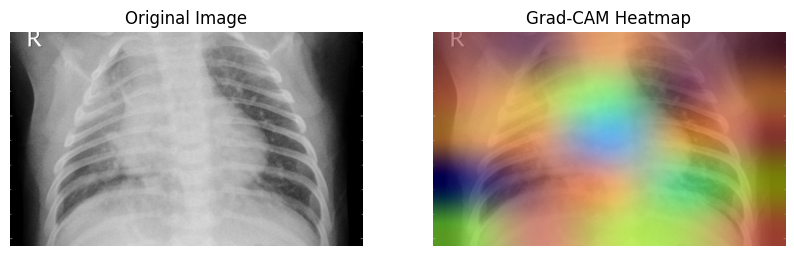

Grad-CAM Generated Successfully!


In [32]:
# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(input_tensor, loaded_model)

# Overlay Grad-CAM heatmap on original image
superimposed_img = show_gradcam(original_img_rgb, heatmap)

# Display results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img_rgb)
plt.axis("off")

# Grad-CAM Visualization
plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(superimposed_img.astype(np.uint8))
plt.axis("off")

plt.show()

print("Grad-CAM Generated Successfully!")

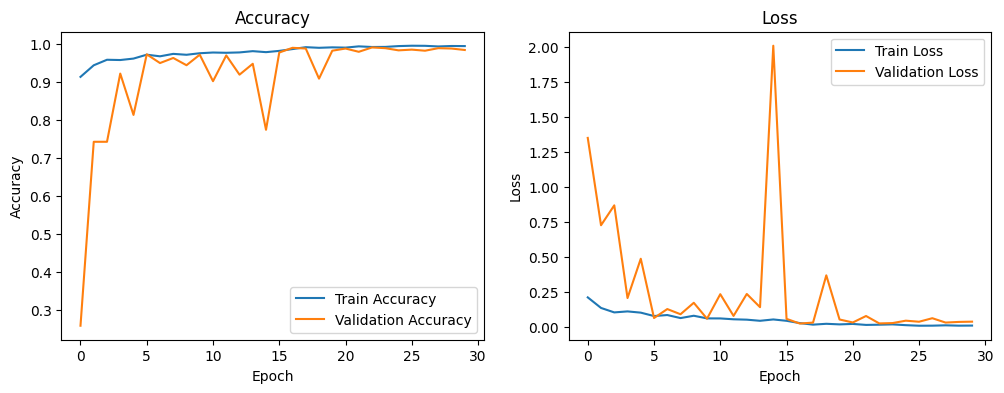

In [19]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 671ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91       234
   PNEUMONIA       0.95      0.95      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624

Overall Test Accuracy: 0.93
AUC-ROC: 0.98
AUC-PR: 0.99
Confusion Matrix:


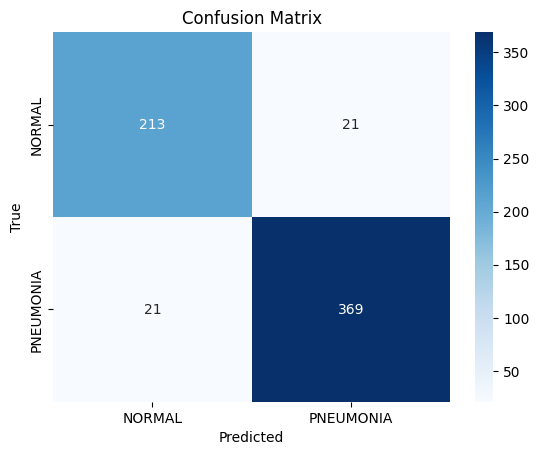

Sensitivity (Recall for PNEUMONIA): 0.95
Specificity (Recall for NORMAL): 0.91


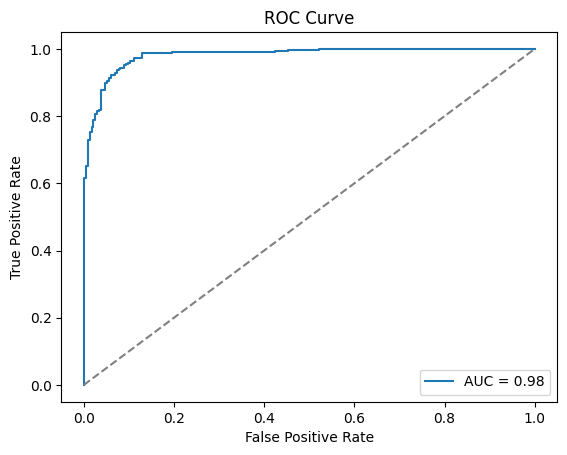

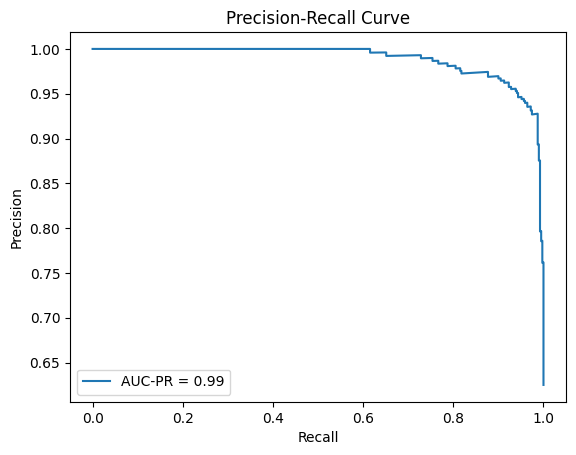

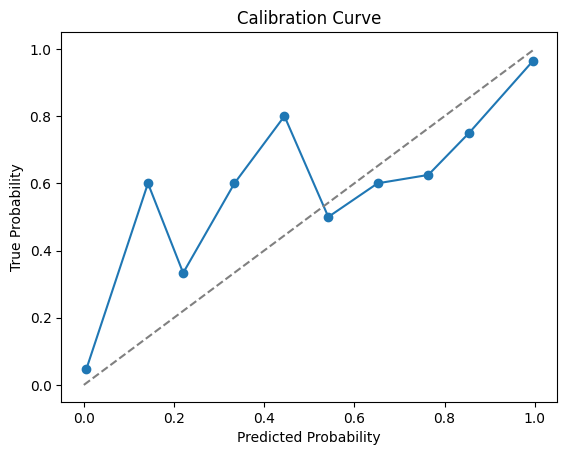

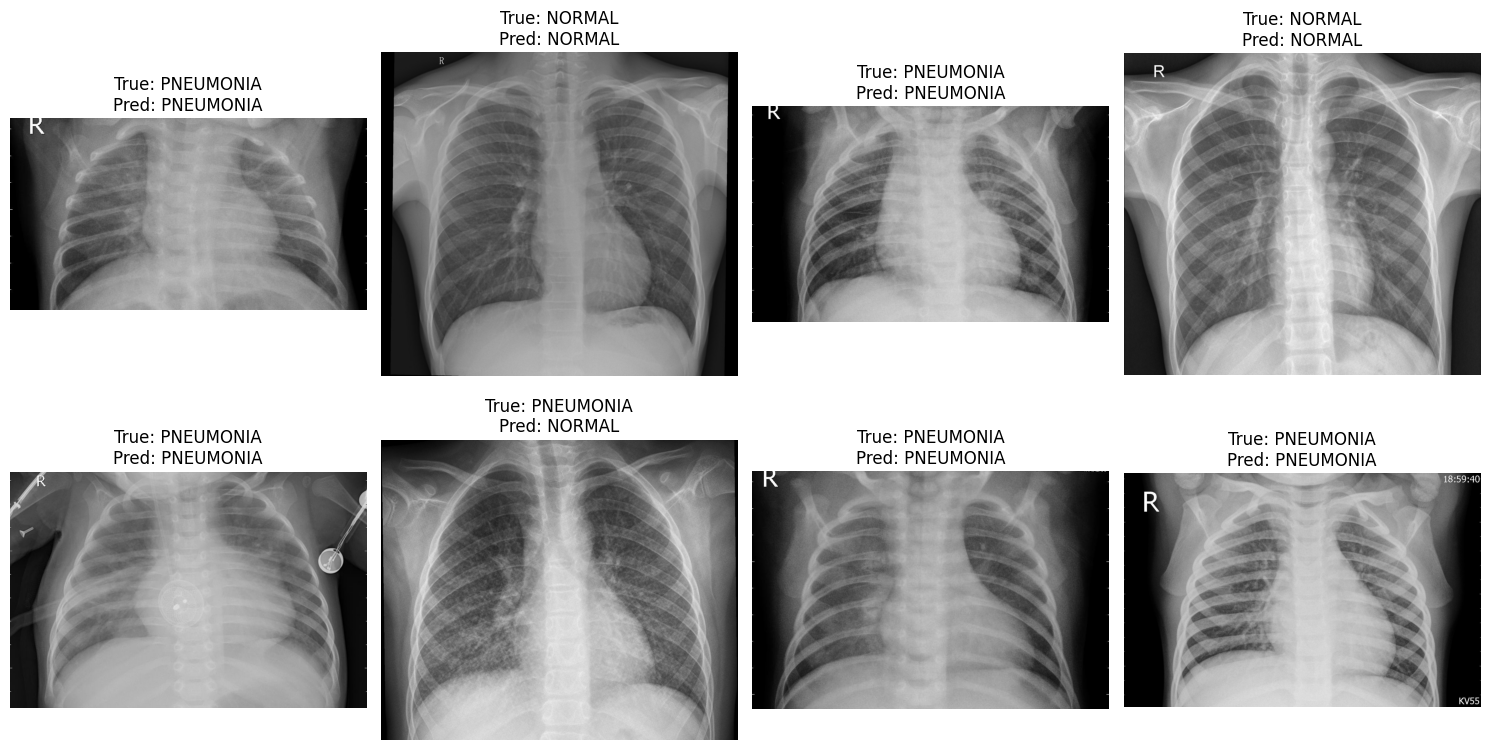

In [20]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc,roc_curve
from sklearn.calibration import calibration_curve
import seaborn as sns

# Enhanced function
def test_and_visualize_with_metrics(model, test_generator):
    # Get predictions and true labels
    predictions = model.predict(test_generator)
    y_true = test_generator.classes  # True labels
    y_pred = (predictions > 0.5).astype(int)  # Predicted labels

    # Class labels
    class_indices = test_generator.class_indices
    class_names = list(class_indices.keys())

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Overall accuracy
    from sklearn.metrics import accuracy_score
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Test Accuracy: {overall_accuracy:.2f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, predictions)
    print(f"AUC-ROC: {auc_roc:.2f}")

    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_true, predictions)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR: {auc_pr:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Sensitivity and Specificity
    TP = cm[1, 1]  # True Positives
    FN = cm[1, 0]  # False Negatives
    FP = cm[0, 1]  # False Positives
    TN = cm[0, 0]  # True Negatives

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"Sensitivity (Recall for PNEUMONIA): {sensitivity:.2f}")
    print(f"Specificity (Recall for NORMAL): {specificity:.2f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal for random guessing
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, predictions, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.show()

    # Visualize random sample predictions
    visualize_results_with_generator(test_generator, predictions, class_names)

# Visualization function remains the same
def visualize_results_with_generator(test_generator, predictions, class_names):
    # Display a few images with predictions
    filepaths = test_generator.filepaths
    true_labels = test_generator.classes
    predicted_labels = (predictions > 0.5).astype(int)

    # Select a few images for visualization
    sample_indices = np.random.choice(len(filepaths), size=8, replace=False)
    sample_images = [filepaths[i] for i in sample_indices]
    sample_predictions = [predicted_labels[i] for i in sample_indices]
    sample_true_labels = [true_labels[i] for i in sample_indices]

    # Plot images with predictions
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = class_names[sample_true_labels[i]]
        pred_label = class_names[sample_predictions[i][0]]

        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the enhanced function
test_and_visualize_with_metrics(model, test_generator)